In [82]:
from scipy.optimize import fsolve, least_squares
import numpy as np
import random
import matplotlib.pyplot as plt

In [83]:
def tdoa_trilateration_fs(mic_locations, time_diffs):
    # mic_locations: list of tuples containing microphone locations
    # time_diffs: list of tuples containing pairs of microphone indices and corresponding time differences
    
    c = 343.0 # speed of sound in air (m/s)
    
    def equations(p):
        x, y = p
        eqns = []
        for mic_pair, time_diff in time_diffs:
            i, j = mic_pair
            eqn = (np.sqrt((x - mic_locations[i][0])**2 + (y - mic_locations[i][1])**2) - np.sqrt((x - mic_locations[j][0])**2 + (y - mic_locations[j][1])**2)) - c * time_diff
            eqns.append(eqn)
        return eqns
    
    x, y = fsolve(equations, (0, 0))
    
    return x, y

def tdoa_trilateration_ls(mic_locations, time_diffs):
    # mic_locations: list of tuples containing microphone locations
    # time_diffs: list of tuples containing pairs of microphone indices and corresponding time differences
    
    c = 343.0 # speed of sound in air (m/s)
    
    def equations(p):
        x, y = p
        eqns = []
        for mic_pair, time_diff in time_diffs:
            i, j = mic_pair
            eqn = (np.sqrt((x - mic_locations[i][0])**2 + (y - mic_locations[i][1])**2) - np.sqrt((x - mic_locations[j][0])**2 + (y - mic_locations[j][1])**2)) - c * time_diff
            eqns.append(eqn)
        return eqns
    
    res = least_squares(equations, (0, 0))
    x, y = res.x
    
    return x, y

def tdoa_trilateration(mic_locations, time_diffs):
    if len(mic_locations) == 3:
        return tdoa_trilateration_fs(mic_locations, time_diffs)
    else:
        return tdoa_trilateration_ls(mic_locations, time_diffs)


In [84]:
def generate_random_tdoa_data(xmin, xmax, c=343.0, n=3, epsilon=1, noise=0.0):
    # Generate random sound location
    sound_loc = (random.uniform(xmin, xmax), random.uniform(xmin, xmax))
    
    # Generate random microphone locations
    mic_locations = [(random.uniform(xmin, xmax), random.uniform(xmin, xmax))]
    
    # Calculate time differences between pairs of microphones
    time_diffs = []
    for i in range(1, n):
        # Add a new microphone
        mic_locations.append((random.uniform(xmin, xmax), random.uniform(xmin, xmax)))

        # Ensure that new points are at least epsilon distance away from each other
        while np.sqrt((mic_locations[i][0] - mic_locations[i-1][0])**2 + (mic_locations[i][1] - mic_locations[i-1][1])**2) < epsilon:
            mic_locations[i] = (random.uniform(xmin, xmax), random.uniform(xmin, xmax))


        # Select one of the previous microphones as a parther for the new microphone
        j = random.randint(0, i-1)

        d1 = np.sqrt((sound_loc[0] - mic_locations[i][0])**2 + (sound_loc[1] - mic_locations[i][1])**2)
        d2 = np.sqrt((sound_loc[0] - mic_locations[j][0])**2 + (sound_loc[1] - mic_locations[j][1])**2)
        time_diff = (d1 - d2) / c
        time_diff += random.uniform(-noise, noise)
        time_diffs.append(((i, j), time_diff))
    
    return sound_loc, mic_locations, time_diffs


Deviation: 3.1957650171062633


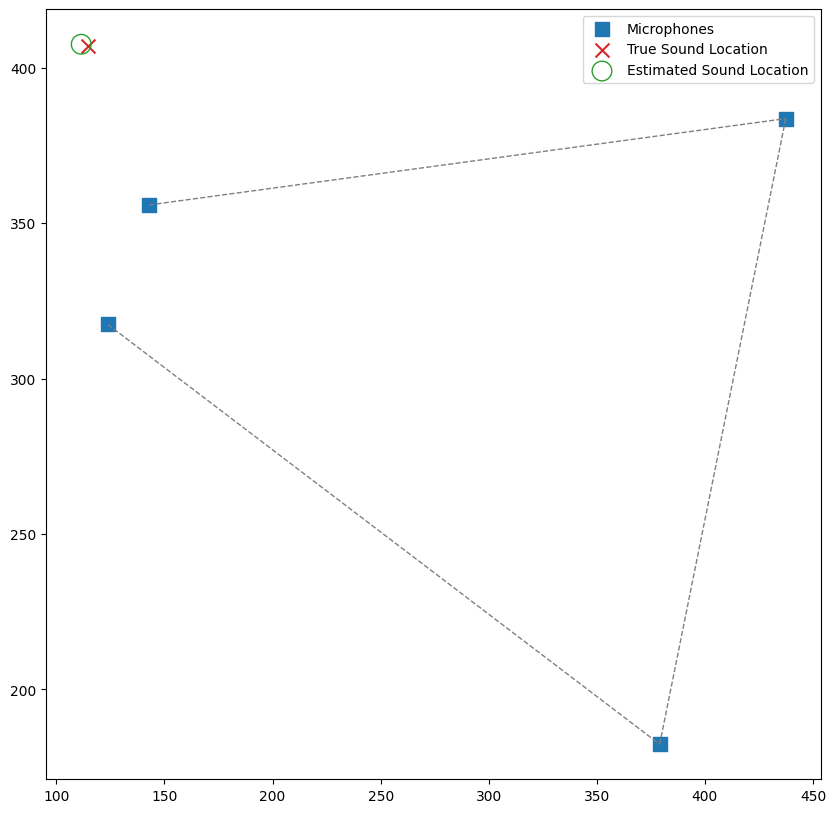

In [97]:
sound_loc, mic_locations, time_diffs = generate_random_tdoa_data(0, 500, n=4, noise=0.01)
# print('Sound Location: {}'.format(sound_loc))
# print('Microphone Locations: {}'.format(mic_locations))
# print('Time Differences: {}'.format(time_diffs))

# Estimate sound location
est_loc = tdoa_trilateration(mic_locations, time_diffs)

print(f'Deviation: {np.sqrt((sound_loc[0] - est_loc[0])**2 + (sound_loc[1] - est_loc[1])**2)}')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot sound location, microphone locations, and estimated sound source location
ax.scatter(*zip(*mic_locations), color='tab:blue', label='Microphones', s=100, marker='s')
ax.scatter(*sound_loc, color='tab:red', label='True Sound Location', s=100, marker='x')
ax.scatter(*est_loc, color='tab:green', label='Estimated Sound Location', facecolors='none', s=200, marker='o')

# Plot faint lines between microphone pairs
for mic_pair, time_diff in time_diffs:
    i, j = mic_pair
    x1, y1 = mic_locations[i]
    x2, y2 = mic_locations[j]
    ax.plot([x1, x2], [y1, y2], color='gray', linestyle='dashed', linewidth=1)

ax.legend();